# Tesla Stock Prediction from Reddit Sentiment

Machine Learning pipeline to predict Tesla stock price movements based on Reddit posts sentiment analysis.

## Data Loading and Preprocessing

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

In [97]:
# Lade die vorverarbeiteten Daten
combined_features = np.load('data/embeddings_complete.npy')
reddit_df = pd.read_csv('data/tesla_sentiment_complete.csv')
stock_df = pd.read_csv('data/TSLA_weekly_adjusted.csv')

print(f"✅ Daten erfolgreich geladen:")
print(f"   🧠 Kombinierte Features: {combined_features.shape}")
print(f"   📝 Reddit Metadaten: {len(reddit_df)} Posts")  
print(f"   📈 Tesla Kursdaten: {len(stock_df)} Wochen")

# Überprüfe Datenintegrität
assert len(combined_features) == len(reddit_df), f"Shape mismatch: {len(combined_features)} vs {len(reddit_df)}"

# Zeige Feature-Struktur basierend auf combine.ipynb:
# Spalten 0-1023: Embeddings (1024D)
# Spalten 1024-1025: Sentiment Features (FinBERT, VADER) 
# Spalte 1026: Log-skalierte Upvotes
print(f"Feature-Dimensionen: {combined_features.shape[1]} insgesamt (1024 Embeddings + 3 Meta-Features)")

✅ Daten erfolgreich geladen:
   🧠 Kombinierte Features: (13268, 1027)
   📝 Reddit Metadaten: 13268 Posts
   📈 Tesla Kursdaten: 780 Wochen
Feature-Dimensionen: 1027 insgesamt (1024 Embeddings + 3 Meta-Features)


In [98]:
# Datenübersicht der geladenen Daten
print("\n=== REDDIT METADATEN ÜBERSICHT ===")
print("Reddit Posts:")
print(reddit_df.head())
print(f"\nSpalten: {list(reddit_df.columns)}")

reddit_df['created'] = pd.to_datetime(reddit_df['created'])
reddit_df['date'] = reddit_df['created'].dt.date

print(f"Reddit Datum-Range: {reddit_df['date'].min()} bis {reddit_df['date'].max()}")

if 'finbert_sentiment' in reddit_df.columns:
    print(f"FinBERT Sentiment Range: {reddit_df['finbert_sentiment'].min():.3f} bis {reddit_df['finbert_sentiment'].max():.3f}")

if 'vader_sentiment' in reddit_df.columns:
    print(f"VADER Sentiment Range: {reddit_df['vader_sentiment'].min():.3f} bis {reddit_df['vader_sentiment'].max():.3f}")
        
if 'score' in reddit_df.columns:
    print(f"Upvotes (Score) Range: {reddit_df['score'].min()} bis {reddit_df['score'].max()}")

print("\n=== TESLA KURSDATEN ÜBERSICHT ===")
print("Stock Data:")
print(stock_df.head())
print(f"\nSpalten: {list(stock_df.columns)}")

# Stock-Daten vorbereiten  
stock_df['date'] = pd.to_datetime(stock_df['date'])
stock_df['date_only'] = stock_df['date'].dt.date

print(f"Kursdaten von {stock_df['date_only'].min()} bis {stock_df['date_only'].max()}")
print(f"Close-Preis Range: ${stock_df['close'].min():.2f} bis ${stock_df['close'].max():.2f}")

print(f"\n🧠 Kombinierte Features Shape: {combined_features.shape}")
print(f"📊 Reddit Posts: {len(reddit_df)}")
print(f"📈 Stock Data Points: {len(stock_df)}")


=== REDDIT METADATEN ÜBERSICHT ===
Reddit Posts:
                               title  \
0   Bowl-O-Matic™ Picks for 7-2-2012   
1   Bowl-O-Matic™ Picks for 7-6-2012   
2   Bowl-O-Matic™ Picks for 7-9-2012   
3  Bowl-O-Matic™ Picks for 7-10-2012   
4  Bowl-O-Matic™ Picks for 7-12-2012   

                                                text  score  \
0  * * Long : * * * SLV * ARNA * ROSG * IMAX * PP...     11   
1  * * Long : * * * CYH * EXPE * V * PPG * TRIP *...     10   
2  * * Long : * * * BUD * CYH * EQIX * HCA * SGEN...      7   
3  * * Long : * * * ALXN * CL * BUD * HFC * DTV *...      6   
4  * * Long : * * * CL * FDX * UPS * EQT * AGU * ...      6   

               created                                          full_text  \
0  2012-06-30 03:41:00  Bowl-O-Matic™ Picks for 7-2-2012 * * Long : * ...   
1  2012-07-06 01:03:00  Bowl-O-Matic™ Picks for 7-6-2012 * * Long : * ...   
2  2012-07-09 14:32:00  Bowl-O-Matic™ Picks for 7-9-2012 * * Long : * ...   
3  2012-07-10 00:47:00

## Weekly Aggregation and Label Creation

Posts werden wochenweise (Freitag bis Freitag) gruppiert, um alle Posts zu berücksichtigen und bessere Übereinstimmung mit wöchentlichen Kursdaten zu erreichen.

In [99]:
# Weekly grouping: Friday to Friday
def get_trading_week(date):
    """
    Bestimmt die Handelswoche (Freitag bis Freitag)
    Gibt das Datum des Freitags zurück, der die Woche definiert
    """
    # Wochentag: 0=Montag, 1=Dienstag, ..., 6=Sonntag, 4=Freitag
    weekday = date.weekday()
    
    if weekday == 4:  # Freitag
        return date
    elif weekday < 4:  # Montag bis Donnerstag
        # Gehört zur vorherigen Woche (letzter Freitag)
        days_since_friday = weekday + 3  # Mo=3, Di=2, Mi=1, Do=0 Tage zurück
        return date - timedelta(days=days_since_friday)
    else:  # Samstag, Sonntag
        # Gehört zur nächsten Woche (nächster Freitag)
        days_to_friday = 4 - weekday + 7  # Sa=5, So=6 Tage vorwärts
        return date + timedelta(days=days_to_friday)

# Prepare Reddit data with weekly grouping
reddit_df['created'] = pd.to_datetime(reddit_df['created'])
reddit_df['date'] = reddit_df['created'].dt.date
reddit_df['trading_week'] = reddit_df['date'].apply(get_trading_week)

print(f"Reddit posts: {reddit_df['date'].min()} to {reddit_df['date'].max()}")
print(f"Trading weeks: {reddit_df['trading_week'].min()} to {reddit_df['trading_week'].max()}")

# Group posts by trading week and aggregate features
def aggregate_weekly_features(reddit_df, combined_features):
    """
    Aggregiert Reddit Posts und Features nach Handelswochen (Freitag-Freitag)
    """
    weekly_data = []
    
    # Gruppiere nach trading_week
    for week, group in reddit_df.groupby('trading_week'):
        indices = group.index.tolist()
        
        # Hole entsprechende Features für diese Woche
        week_features = combined_features[indices]
        
        # Aggregiere Features:
        # - Embeddings (0-1023): Durchschnitt
        # - FinBERT Sentiment (1024): Gewichteter Durchschnitt nach Upvotes
        # - VADER Sentiment (1025): Gewichteter Durchschnitt nach Upvotes  
        # - Log Upvotes (1026): Summe (total engagement)
        
        upvotes = group['score'].values if 'score' in group.columns else np.ones(len(group))
        upvotes_weights = upvotes / upvotes.sum() if upvotes.sum() > 0 else np.ones(len(upvotes)) / len(upvotes)
        
        # Aggregierte Features
        aggregated_features = np.zeros(1027)
        
        # Embeddings: Gewichteter Durchschnitt
        aggregated_features[:1024] = np.average(week_features[:, :1024], axis=0, weights=upvotes_weights)
        
        # FinBERT: Gewichteter Durchschnitt
        aggregated_features[1024] = np.average(week_features[:, 1024], weights=upvotes_weights)
        
        # VADER: Gewichteter Durchschnitt
        aggregated_features[1025] = np.average(week_features[:, 1025], weights=upvotes_weights)
        
        # Log Upvotes: Summe aller Posts in der Woche (aber weiterhin log-skaliert)
        total_upvotes = upvotes.sum()
        aggregated_features[1026] = np.log1p(total_upvotes)
        
        weekly_data.append({
            'trading_week': week,
            'post_count': len(group),
            'total_upvotes': total_upvotes,
            'features': aggregated_features,
            'avg_finbert': np.average(week_features[:, 1024], weights=upvotes_weights),
            'avg_vader': np.average(week_features[:, 1025], weights=upvotes_weights)
        })
    
    return weekly_data

# Aggregiere Features wöchentlich
weekly_data = aggregate_weekly_features(reddit_df, combined_features)

print(f"\n📊 Wöchentliche Aggregation:")
print(f"   • {len(weekly_data)} Handelswochen")
print(f"   • Durchschnitt {np.mean([w['post_count'] for w in weekly_data]):.1f} Posts pro Woche")
print(f"   • Features pro Woche: {weekly_data[0]['features'].shape}")

# Erstelle aggregierte DataFrames
weekly_reddit_df = pd.DataFrame([
    {
        'trading_week': w['trading_week'],
        'post_count': w['post_count'], 
        'total_upvotes': w['total_upvotes'],
        'avg_finbert': w['avg_finbert'],
        'avg_vader': w['avg_vader']
    } for w in weekly_data
])

weekly_features = np.array([w['features'] for w in weekly_data])

print(f"✅ Wöchentliche Aggregation abgeschlossen")
print(f"   • Weekly Reddit DF: {weekly_reddit_df.shape}")
print(f"   • Weekly Features: {weekly_features.shape}")

# Verify feature consistency
finbert_match = np.allclose(weekly_reddit_df['avg_finbert'].values, weekly_features[:, 1024], atol=1e-6)
vader_match = np.allclose(weekly_reddit_df['avg_vader'].values, weekly_features[:, 1025], atol=1e-6)
print(f"FinBERT consistency: {'✓' if finbert_match else '✗'}")
print(f"VADER consistency: {'✓' if vader_match else '✗'}")

Reddit posts: 2012-06-30 to 2024-12-31
Trading weeks: 2012-07-06 to 2025-01-03

📊 Wöchentliche Aggregation:
   • 552 Handelswochen
   • Durchschnitt 24.0 Posts pro Woche
   • Features pro Woche: (1027,)
✅ Wöchentliche Aggregation abgeschlossen
   • Weekly Reddit DF: (552, 5)
   • Weekly Features: (552, 1027)
FinBERT consistency: ✓
VADER consistency: ✓

📊 Wöchentliche Aggregation:
   • 552 Handelswochen
   • Durchschnitt 24.0 Posts pro Woche
   • Features pro Woche: (1027,)
✅ Wöchentliche Aggregation abgeschlossen
   • Weekly Reddit DF: (552, 5)
   • Weekly Features: (552, 1027)
FinBERT consistency: ✓
VADER consistency: ✓


In [100]:
# Tesla Kursdaten verarbeiten
stock_df['date'] = pd.to_datetime(stock_df['date'])
stock_df['date_only'] = stock_df['date'].dt.date

# Bereite Kursdaten vor
stock_df = stock_df.sort_values('date').reset_index(drop=True)
stock_dict = dict(zip(stock_df['date_only'], stock_df['close']))

# Überprüfe Überschneidung zwischen Reddit Posts und Kursdaten
reddit_date_range = (reddit_df['date'].min(), reddit_df['date'].max())
stock_date_range = (stock_df['date_only'].min(), stock_df['date_only'].max())

print(f"📅 Datums-Überschneidung:")
print(f"   • Reddit Posts: {reddit_date_range[0]} bis {reddit_date_range[1]}")
print(f"   • Tesla Kursdaten: {stock_date_range[0]} bis {stock_date_range[1]}")

# Prüfe wie viele Reddit Posts Kursdaten haben
posts_with_prices = sum(1 for date in reddit_df['date'] if date in stock_dict)
print(f"Posts mit Kursdaten: {posts_with_prices}/{len(reddit_df)} ({posts_with_prices/len(reddit_df)*100:.1f}%)")

print(f"\n✅ Kursdaten erfolgreich vorbereitet")

# Prepare stock data for weekly matching
stock_df = stock_df.sort_values('date').reset_index(drop=True)

# Erweitere Stock-Daten um trading_week
stock_df['trading_week'] = stock_df['date_only'].apply(get_trading_week)

# Erstelle Dictionary für schnellen Zugriff (nach trading_week)
stock_weekly_dict = dict(zip(stock_df['trading_week'], stock_df['close']))

print(f"📈 Stock data weeks: {len(stock_df)} entries")
print(f"📈 Unique trading weeks in stock data: {len(set(stock_df['trading_week']))}")

# Check overlap between weekly Reddit data and stock data
reddit_weeks = set(weekly_reddit_df['trading_week'])
stock_weeks = set(stock_df['trading_week'])
overlapping_weeks = reddit_weeks.intersection(stock_weeks)

print(f"\n📅 Weekly overlap:")
print(f"   • Reddit weeks: {len(reddit_weeks)}")
print(f"   • Stock weeks: {len(stock_weeks)}")
print(f"   • Overlapping weeks: {len(overlapping_weeks)} ({len(overlapping_weeks)/len(reddit_weeks)*100:.1f}%)")

print(f"✅ Stock data prepared for weekly matching")

📅 Datums-Überschneidung:
   • Reddit Posts: 2012-06-30 bis 2024-12-31
   • Tesla Kursdaten: 2010-07-09 bis 2025-06-11
Posts mit Kursdaten: 1977/13268 (14.9%)

✅ Kursdaten erfolgreich vorbereitet
📈 Stock data weeks: 780 entries
📈 Unique trading weeks in stock data: 757

📅 Weekly overlap:
   • Reddit weeks: 552
   • Stock weeks: 757
   • Overlapping weeks: 537 (97.3%)
✅ Stock data prepared for weekly matching


In [101]:
# Create labels based on weekly data: Stock goes up in next X weeks?
PREDICTION_WEEKS = 1  # Predict 1 week ahead (instead of days)

def create_weekly_labels(weekly_reddit_df, stock_df, prediction_weeks=1):
    """
    Erstellt Labels basierend auf wöchentlichen Daten:
    1 = Kurs steigt in den nächsten X Wochen
    0 = Kurs fällt oder bleibt gleich
    """
    labels = []
    valid_indices = []
    
    # Stock data als Dictionary nach trading_week
    stock_weekly_dict = dict(zip(stock_df['trading_week'], stock_df['close']))
    stock_weeks_list = sorted(stock_df['trading_week'].unique())
    
    for idx, row in weekly_reddit_df.iterrows():
        reddit_week = row['trading_week']
        
        # Aktueller Preis für diese Woche
        if reddit_week not in stock_weekly_dict:
            continue
        current_price = stock_weekly_dict[reddit_week]
        
        # Future-Preis (X Wochen später)
        future_week = None
        current_week_idx = None
        
        try:
            current_week_idx = stock_weeks_list.index(reddit_week)
            future_week_idx = current_week_idx + prediction_weeks
            
            if future_week_idx < len(stock_weeks_list):
                future_week = stock_weeks_list[future_week_idx]
                future_price = stock_weekly_dict[future_week]
                
                # Label: 1 wenn Kurs steigt, 0 wenn fällt/gleich
                label = 1 if future_price > current_price else 0
                labels.append(label)
                valid_indices.append(idx)
                
        except (ValueError, IndexError):
            continue
    
    return labels, valid_indices

# Labels erstellen
labels, valid_indices = create_weekly_labels(weekly_reddit_df, stock_df, PREDICTION_WEEKS)

print(f"✅ Weekly labels created for {len(labels)} weeks")
if len(labels) > 0:
    print(f"📊 Distribution:")
    print(f"   • Stock rises: {sum(labels)} weeks ({sum(labels)/len(labels)*100:.1f}%)")
    print(f"   • Stock falls: {len(labels)-sum(labels)} weeks ({(len(labels)-sum(labels))/len(labels)*100:.1f}%)")
    
    # Details zur Abdeckung
    total_weeks = len(weekly_reddit_df)
    coverage = len(labels) / total_weeks
    print(f"   • Coverage: {len(labels)}/{total_weeks} weeks ({coverage*100:.1f}%)")
else:
    print("❌ No labels created - check data alignment!")

✅ Weekly labels created for 537 weeks
📊 Distribution:
   • Stock rises: 301 weeks (56.1%)
   • Stock falls: 236 weeks (43.9%)
   • Coverage: 537/552 weeks (97.3%)


In [102]:
# Prepare weekly training dataset
train_weekly_reddit = weekly_reddit_df.iloc[valid_indices].copy()
train_labels = np.array(labels)
train_features = weekly_features[valid_indices]

# Feature names for interpretability  
feature_names = []
feature_names.extend([f'embed_{i}' for i in range(1024)])  # Embeddings (0-1023)
feature_names.append('finbert_sentiment')  # Feature 1024
feature_names.append('vader_sentiment')    # Feature 1025  
feature_names.append('log_total_upvotes')  # Feature 1026 (now weekly sum)

print(f"🧠 Weekly features prepared: {train_features.shape}")
print(f"📝 Training data: {len(train_weekly_reddit)} weeks")
print(f"🎯 Labels: {len(train_labels)} (stock rises/falls)")
print(f"⚖️ Label distribution: {train_labels.mean():.1%} rises, {1-train_labels.mean():.1%} falls")

# Show weekly aggregation stats
print(f"\n📊 Weekly aggregation stats:")
print(f"   • Avg posts per week: {train_weekly_reddit['post_count'].mean():.1f}")
print(f"   • Avg upvotes per week: {train_weekly_reddit['total_upvotes'].mean():.0f}")
print(f"   • Avg FinBERT sentiment: {train_weekly_reddit['avg_finbert'].mean():.3f}")
print(f"   • Avg VADER sentiment: {train_weekly_reddit['avg_vader'].mean():.3f}")

🧠 Weekly features prepared: (537, 1027)
📝 Training data: 537 weeks
🎯 Labels: 537 (stock rises/falls)
⚖️ Label distribution: 56.1% rises, 43.9% falls

📊 Weekly aggregation stats:
   • Avg posts per week: 24.0
   • Avg upvotes per week: 19506
   • Avg FinBERT sentiment: 0.595
   • Avg VADER sentiment: 0.160


## 3. Feature Engineering

In [103]:
# Feature engineering for weekly data
def add_weekly_features(weekly_reddit_df, features):
    """
    Fügt wöchentliche Meta-Features hinzu
    """
    weekly_df_copy = weekly_reddit_df.copy()
    
    # Zeitbasierte Features aus trading_week
    weekly_df_copy['week_of_year'] = pd.to_datetime(weekly_df_copy['trading_week']).dt.isocalendar().week
    weekly_df_copy['month'] = pd.to_datetime(weekly_df_copy['trading_week']).dt.month
    weekly_df_copy['quarter'] = pd.to_datetime(weekly_df_copy['trading_week']).dt.quarter
    
    # Engagement-Features
    weekly_df_copy['log_post_count'] = np.log1p(weekly_df_copy['post_count'])
    weekly_df_copy['upvotes_per_post'] = weekly_df_copy['total_upvotes'] / weekly_df_copy['post_count']
    
    # Neue Features als Array
    new_features = np.column_stack([
        weekly_df_copy['week_of_year'].values,
        weekly_df_copy['month'].values, 
        weekly_df_copy['quarter'].values,
        weekly_df_copy['log_post_count'].values,
        weekly_df_copy['upvotes_per_post'].values
    ])
    
    # Kombiniere mit bestehenden Features
    extended_features = np.concatenate([features, new_features], axis=1)
    
    # Erweiterte Feature-Namen
    extended_names = feature_names + [
        'week_of_year', 'month', 'quarter', 
        'log_post_count', 'upvotes_per_post'
    ]
    
    return extended_features, extended_names

# Features erweitern
X_extended, feature_names_extended = add_weekly_features(train_weekly_reddit, train_features)
y = train_labels

print(f"✅ Weekly features extended: {X_extended.shape}")
print(f"📊 Feature breakdown:")
print(f"   • Embeddings: 1024D (columns 0-1023)")
print(f"   • FinBERT sentiment: 1D (column 1024)")
print(f"   • VADER sentiment: 1D (column 1025)")
print(f"   • Log total upvotes: 1D (column 1026)")
print(f"   • Weekly meta-features: 5D (week, month, quarter, log_posts, upvotes_per_post)")
print(f"   • Total: {len(feature_names_extended)} features")
print(f"🎯 Labels: {y.shape}, Positive class: {y.mean():.2%}")

# Use extended features as main features
X = X_extended
feature_names = feature_names_extended

✅ Weekly features extended: (537, 1032)
📊 Feature breakdown:
   • Embeddings: 1024D (columns 0-1023)
   • FinBERT sentiment: 1D (column 1024)
   • VADER sentiment: 1D (column 1025)
   • Log total upvotes: 1D (column 1026)
   • Weekly meta-features: 5D (week, month, quarter, log_posts, upvotes_per_post)
   • Total: 1032 features
🎯 Labels: (537,), Positive class: 56.05%


## 4. Modell Training

In [104]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Training: {X_train.shape[0]} Samples")
print(f"📊 Test: {X_test.shape[0]} Samples")

# Features skalieren
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features skaliert")

📊 Training: 429 Samples
📊 Test: 108 Samples
✅ Features skaliert


In [105]:
# Modelle trainieren
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
}

results = {}

for name, model in models.items():
    print(f"🚀 Trainiere {name}...")
    
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_prob
    }
    
    print(f"✅ {name}: Accuracy = {accuracy:.3f}, ROC-AUC = {roc_auc:.3f}")

print("\n🏆 Training abgeschlossen!")

🚀 Trainiere Logistic Regression...
✅ Logistic Regression: Accuracy = 0.556, ROC-AUC = 0.575
🚀 Trainiere Random Forest...
✅ Logistic Regression: Accuracy = 0.556, ROC-AUC = 0.575
🚀 Trainiere Random Forest...
✅ Random Forest: Accuracy = 0.546, ROC-AUC = 0.588

🏆 Training abgeschlossen!
✅ Random Forest: Accuracy = 0.546, ROC-AUC = 0.588

🏆 Training abgeschlossen!


## 5. Evaluation und Visualisierung

In [106]:
# Detaillierte Evaluation
for name, result in results.items():
    print(f"\n{'='*50}")
    print(f"📊 EVALUATION: {name}")
    print(f"{'='*50}")
    
    print(f"Accuracy: {result['accuracy']:.3f}")
    print(f"ROC-AUC: {result['roc_auc']:.3f}")


📊 EVALUATION: Logistic Regression
Accuracy: 0.556
ROC-AUC: 0.575

📊 EVALUATION: Random Forest
Accuracy: 0.546
ROC-AUC: 0.588


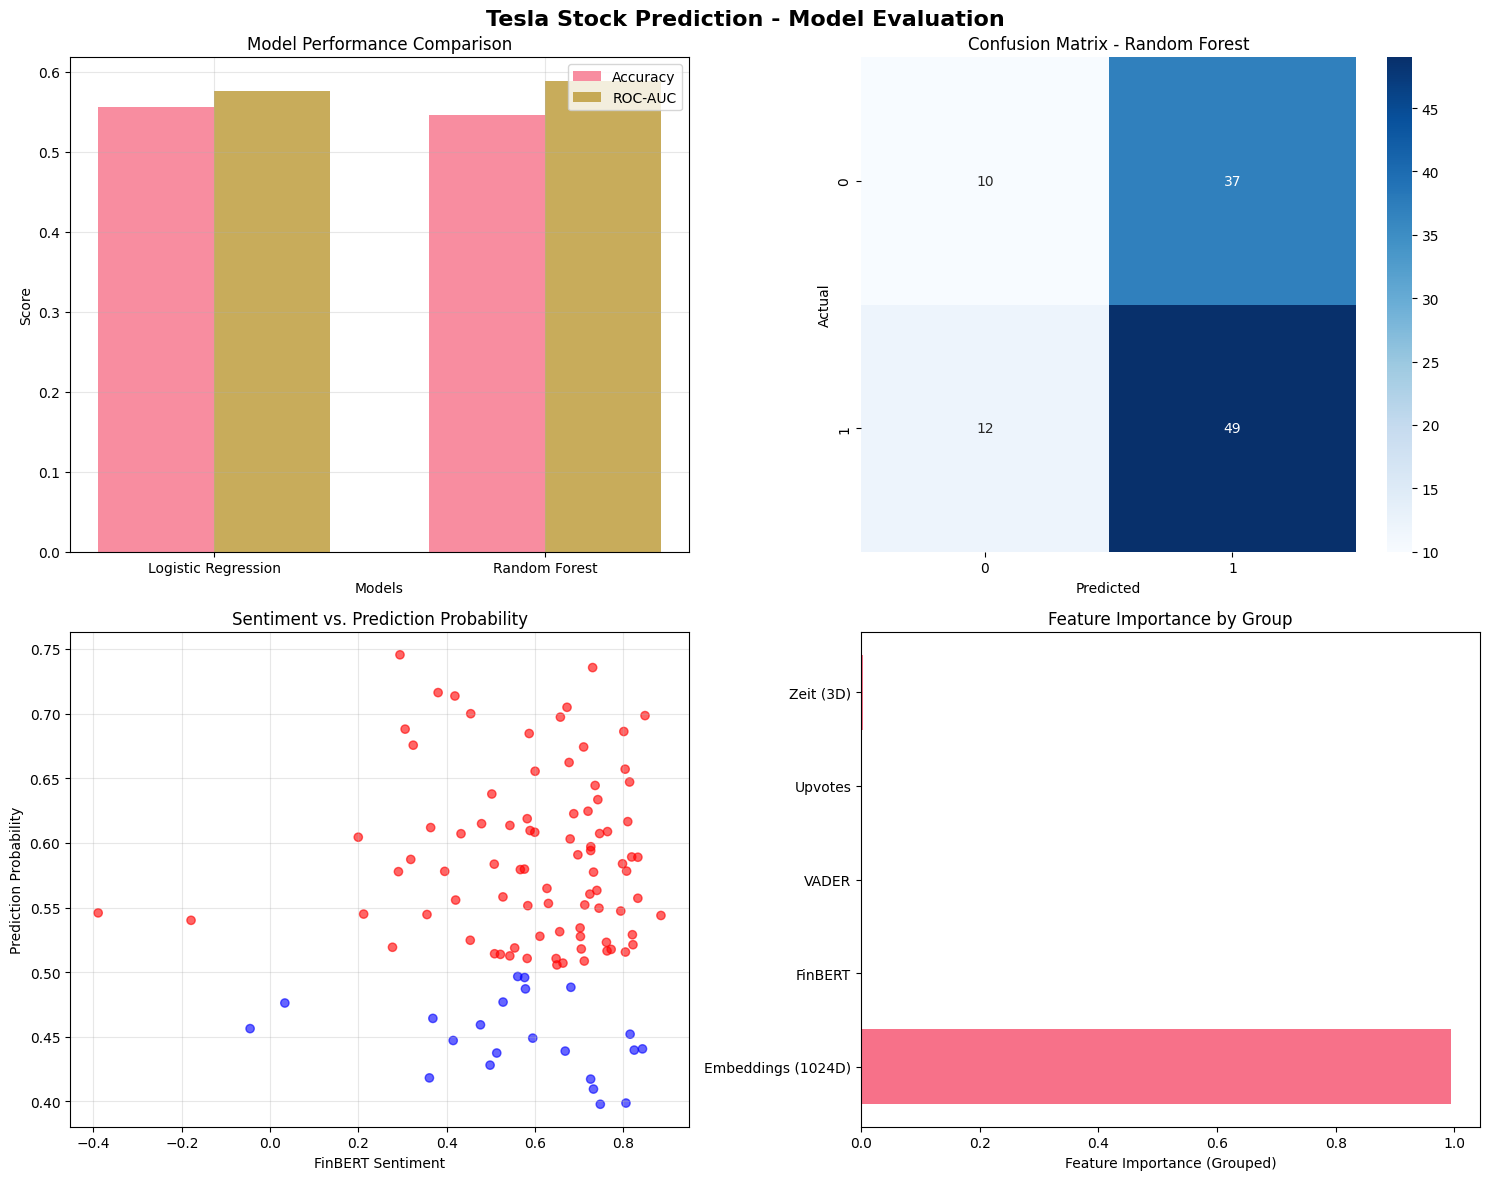


🏆 Bestes Modell: Random Forest (ROC-AUC: 0.588)

📊 FEATURE-ANALYSE:
   • FinBERT-VADER Korrelation: 0.002
   • FinBERT-Label Korrelation: 0.034
   • VADER-Label Korrelation: 0.023
   • Upvotes-Label Korrelation: -0.016


In [107]:
# Visualisierungen
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Tesla Stock Prediction - Model Evaluation', fontsize=16, fontweight='bold')

# Modell-Vergleich
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
roc_aucs = [results[name]['roc_auc'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[0,0].bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
axes[0,0].bar(x + width/2, roc_aucs, width, label='ROC-AUC', alpha=0.8)
axes[0,0].set_xlabel('Models')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Model Performance Comparison')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(model_names)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Confusion Matrix (bestes Modell)
best_model_name = max(results.keys(), key=lambda x: results[x]['roc_auc'])
cm = confusion_matrix(y_test, results[best_model_name]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title(f'Confusion Matrix - {best_model_name}')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# FinBERT Sentiment vs. Predictions
finbert_sentiment_test = X_test[:, 1024]
colors = ['red' if pred == 1 else 'blue' for pred in results[best_model_name]['predictions']]
axes[1,0].scatter(finbert_sentiment_test, results[best_model_name]['probabilities'], c=colors, alpha=0.6)
axes[1,0].set_xlabel('FinBERT Sentiment')
axes[1,0].set_ylabel('Prediction Probability')
axes[1,0].set_title('Sentiment vs. Prediction Probability')
axes[1,0].grid(True, alpha=0.3)

# Feature Importance (Random Forest)
if best_model_name == 'Random Forest':
    importances = results[best_model_name]['model'].feature_importances_
    
    # Gruppierte Importances
    embedding_importance = importances[:1024].sum()
    finbert_importance = importances[1024]
    vader_importance = importances[1025]
    upvotes_importance = importances[1026] 
    time_importance = importances[1027:].sum()
    
    grouped_features = ['Embeddings (1024D)', 'FinBERT', 'VADER', 'Upvotes', 'Zeit (3D)']
    grouped_importances = [embedding_importance, finbert_importance, vader_importance, upvotes_importance, time_importance]
    
    axes[1,1].barh(range(len(grouped_features)), grouped_importances)
    axes[1,1].set_yticks(range(len(grouped_features)))
    axes[1,1].set_yticklabels(grouped_features)
    axes[1,1].set_xlabel('Feature Importance (Grouped)')
    axes[1,1].set_title('Feature Importance by Group')
else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nnur für Random Forest\nverfügbar', 
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance')

plt.tight_layout()
plt.show()

print(f"\n🏆 Bestes Modell: {best_model_name} (ROC-AUC: {results[best_model_name]['roc_auc']:.3f})")

# Feature-Korrelationen
print(f"\n📊 FEATURE-ANALYSE:")
print(f"   • FinBERT-VADER Korrelation: {np.corrcoef(X[:, 1024], X[:, 1025])[0,1]:.3f}")
print(f"   • FinBERT-Label Korrelation: {np.corrcoef(X[:, 1024], y)[0,1]:.3f}")
print(f"   • VADER-Label Korrelation: {np.corrcoef(X[:, 1025], y)[0,1]:.3f}")
print(f"   • Upvotes-Label Korrelation: {np.corrcoef(X[:, 1026], y)[0,1]:.3f}")

## 6. Prediction Function für neue Posts

In [108]:
def predict_stock_movement(text, sentiment_finbert=None, sentiment_vader=None, upvotes=1, 
                          model_name='best', embedding=None):
    """
    Prognostiziert die Kursbewegung für einen neuen Reddit Post
    AKTUALISIERT für wöchentliches Modell (1032 Features)
    
    Args:
        text: Reddit Post Text
        sentiment_finbert: FinBERT Sentiment Score
        sentiment_vader: VADER Sentiment Score
        upvotes: Anzahl Upvotes
        model_name: Welches Modell verwenden ('best' oder spezifischer Name)
        embedding: 1024D Embedding des Textes
    
    Returns:
        dict: Prognose und Wahrscheinlichkeit
    """
    from datetime import datetime
    
    # Bestes Modell auswählen
    if model_name == 'best':
        model_name = max(results.keys(), key=lambda x: results[x]['roc_auc'])
    
    model = results[model_name]['model']
    
    # Features erstellen (gleiche Struktur wie wöchentliche Trainingsdaten)
    now = datetime.now()
    
    # 1. Embedding (1024D) - Spalten 0-1023
    if embedding is not None and len(embedding) == 1024:
        embed_features = embedding
    else:
        # Fallback: Durchschnitt der Trainings-Embeddings
        embed_features = np.mean(train_features[:, :1024], axis=0)
    
    # 2. FinBERT Sentiment - Spalte 1024
    finbert = sentiment_finbert if sentiment_finbert is not None else 0.0
    
    # 3. VADER Sentiment - Spalte 1025
    vader = sentiment_vader if sentiment_vader is not None else 0.0
    
    # 4. Log Total Upvotes - Spalte 1026  
    log_total_upvotes = np.log1p(upvotes)
    
    # 5. Wöchentliche Meta-Features - Spalten 1027-1031 (wie im Training)
    week_dt = pd.to_datetime(now.date())
    
    week_of_year = week_dt.isocalendar().week
    month = week_dt.month
    quarter = week_dt.quarter
    
    # Simuliere wöchentliche Aggregation für einen einzelnen Post
    post_count = 1  # Ein Post
    log_post_count = np.log1p(post_count)
    upvotes_per_post = upvotes / post_count  # = upvotes
    
    # Alle Features kombinieren (muss exakt 1032 Features ergeben wie im Training)
    features = np.concatenate([
        embed_features,           # 1024 Features (0-1023)
        [finbert],               # 1 Feature (1024)
        [vader],                 # 1 Feature (1025)
        [log_total_upvotes],     # 1 Feature (1026)
        [week_of_year],          # 1 Feature (1027)
        [month],                 # 1 Feature (1028)
        [quarter],               # 1 Feature (1029)
        [log_post_count],        # 1 Feature (1030)
        [upvotes_per_post]       # 1 Feature (1031)
    ])  # Total: 1032 Features
    
    # Verifiziere Feature-Anzahl
    expected_features = len(feature_names_extended)
    if len(features) != expected_features:
        raise ValueError(f"Wrong feature count: {len(features)}, expected {expected_features}")
    
    # Als 2D Array für Sklearn
    X_new = features.reshape(1, -1)
    
    # Skalierung (falls Logistic Regression)
    if model_name == 'Logistic Regression':
        X_new = scaler.transform(X_new)
    
    # Prognose
    prediction = model.predict(X_new)[0]
    probability = model.predict_proba(X_new)[0]
    
    return {
        'prediction': 'STEIGT' if prediction == 1 else 'FÄLLT',
        'confidence': probability[prediction],
        'probability_steigt': probability[1],
        'probability_fällt': probability[0],
        'model_used': model_name,
        'features_used': {
            'embedding_dim': len(embed_features),
            'finbert_sentiment': finbert,
            'vader_sentiment': vader,
            'upvotes_original': upvotes,
            'log_total_upvotes': log_total_upvotes,
            'week_of_year': week_of_year,
            'month': month,
            'quarter': quarter,
            'post_count': post_count,
            'upvotes_per_post': upvotes_per_post,
            'total_features': len(features)
        }
    }

def predict_weekly_stock_movement(posts_data, model_name='best'):
    """
    Prognostiziert wöchentliche Kursbewegung basierend auf aggregierten Reddit Posts
    
    Args:
        posts_data: Dict mit aggregierten Wochendaten:
                   {
                       'embeddings': np.array(1024,),  # Durchschnitts-Embeddings
                       'finbert_sentiment': float,      # Gewichteter Durchschnitt
                       'vader_sentiment': float,        # Gewichteter Durchschnitt  
                       'total_upvotes': int,           # Summe aller Upvotes
                       'post_count': int,              # Anzahl Posts
                       'week_date': datetime.date      # Freitag der Woche (optional)
                   }
        model_name: Welches Modell verwenden ('best' oder spezifischer Name)
    
    Returns:
        dict: Wöchentliche Prognose und Wahrscheinlichkeit
    """
    from datetime import datetime
    
    # Bestes Modell auswählen
    if model_name == 'best':
        model_name = max(results.keys(), key=lambda x: results[x]['roc_auc'])
    
    model = results[model_name]['model']
    
    # Features erstellen (gleiche Struktur wie wöchentliche Trainingsdaten)
    now = datetime.now()
    
    # 1. Embeddings (1024D) - Spalten 0-1023
    if 'embeddings' in posts_data and len(posts_data['embeddings']) == 1024:
        embed_features = posts_data['embeddings']
    else:
        # Fallback: Durchschnitt der Trainings-Embeddings
        embed_features = np.mean(train_features[:, :1024], axis=0)
    
    # 2. FinBERT Sentiment - Spalte 1024
    finbert = posts_data.get('finbert_sentiment', 0.0)
    
    # 3. VADER Sentiment - Spalte 1025
    vader = posts_data.get('vader_sentiment', 0.0)
    
    # 4. Log Total Upvotes - Spalte 1026
    total_upvotes = posts_data.get('total_upvotes', 1)
    log_total_upvotes = np.log1p(total_upvotes)
    
    # 5. Wöchentliche Meta-Features - Spalten 1027-1031
    week_date = posts_data.get('week_date', now.date())
    week_dt = pd.to_datetime(week_date)
    
    week_of_year = week_dt.isocalendar().week
    month = week_dt.month
    quarter = week_dt.quarter
    
    post_count = posts_data.get('post_count', 1)
    log_post_count = np.log1p(post_count)
    upvotes_per_post = total_upvotes / post_count if post_count > 0 else 0
    
    # Alle Features kombinieren (muss exakt 1032 Features ergeben)
    features = np.concatenate([
        embed_features,           # 1024 Features (0-1023)
        [finbert],               # 1 Feature (1024)
        [vader],                 # 1 Feature (1025)
        [log_total_upvotes],     # 1 Feature (1026)
        [week_of_year],          # 1 Feature (1027)
        [month],                 # 1 Feature (1028)
        [quarter],               # 1 Feature (1029)
        [log_post_count],        # 1 Feature (1030)
        [upvotes_per_post]       # 1 Feature (1031)
    ])  # Total: 1032 Features
    
    # Verifiziere Feature-Anzahl
    expected_features = len(feature_names_extended)
    if len(features) != expected_features:
        raise ValueError(f"Wrong feature count: {len(features)}, expected {expected_features}")
    
    # Als 2D Array für Sklearn
    X_new = features.reshape(1, -1)
    
    # Skalierung (falls Logistic Regression)
    if model_name == 'Logistic Regression':
        X_new = scaler.transform(X_new)
    
    # Prognose
    prediction = model.predict(X_new)[0]
    probability = model.predict_proba(X_new)[0]
    
    return {
        'prediction': 'RISES' if prediction == 1 else 'FALLS',
        'confidence': probability[prediction],
        'probability_rises': probability[1],
        'probability_falls': probability[0],
        'model_used': model_name,
        'features_used': {
            'embedding_dim': len(embed_features),
            'finbert_sentiment': finbert,
            'vader_sentiment': vader,
            'total_upvotes': total_upvotes,
            'post_count': post_count,
            'upvotes_per_post': upvotes_per_post,
            'week_of_year': week_of_year,
            'month': month,
            'quarter': quarter,
            'total_features': len(features)
        }
    }

# Test der aktualisierten Prediction Function
print("🧠 Aktuelle Modell-Features:", len(feature_names_extended))
print("🧠 Erwartet vom Modell:", results[max(results.keys(), key=lambda x: results[x]['roc_auc'])]['model'].n_features_in_)

test_prediction = predict_stock_movement(
    text="Tesla is absolutely killing it! Revolutionary technology!",
    sentiment_finbert=0.8,
    sentiment_vader=0.7,
    upvotes=50
)

print("\n🔮 BEISPIEL-PROGNOSE (Single Post):")
print(f"Text: 'Tesla is absolutely killing it! Revolutionary technology!'")
print(f"Prognose: {test_prediction['prediction']}")
print(f"Konfidenz: {test_prediction['confidence']:.1%}")
print(f"Wahrscheinlichkeit Steigt: {test_prediction['probability_steigt']:.1%}")
print(f"Wahrscheinlichkeit Fällt: {test_prediction['probability_fällt']:.1%}")
print(f"Verwendetes Modell: {test_prediction['model_used']}")

# Test mit negativem Sentiment
test_prediction_neg = predict_stock_movement(
    text="Tesla is overvalued and will crash soon!",
    sentiment_finbert=-0.6,
    sentiment_vader=-0.4,
    upvotes=5
)

print("\n🔮 NEGATIVES BEISPIEL (Single Post):")
print(f"Text: 'Tesla is overvalued and will crash soon!'")
print(f"Prognose: {test_prediction_neg['prediction']}")
print(f"Konfidenz: {test_prediction_neg['confidence']:.1%}")  
print(f"Wahrscheinlichkeit Steigt: {test_prediction_neg['probability_steigt']:.1%}")
print(f"Wahrscheinlichkeit Fällt: {test_prediction_neg['probability_fällt']:.1%}")

print(f"\n📊 Feature Details (Single Post):")
print(f"   • Embedding Dimension: {test_prediction['features_used']['embedding_dim']}")
print(f"   • FinBERT: {test_prediction['features_used']['finbert_sentiment']}")
print(f"   • VADER: {test_prediction['features_used']['vader_sentiment']}")
print(f"   • Upvotes: {test_prediction['features_used']['upvotes_original']}")
print(f"   • Total Features: {test_prediction['features_used']['total_features']}")
print(f"   • Week/Month/Quarter: {test_prediction['features_used']['week_of_year']}/{test_prediction['features_used']['month']}/{test_prediction['features_used']['quarter']}")

# Test der Weekly Prediction Function
test_week_data = {
    'finbert_sentiment': 0.6,
    'vader_sentiment': 0.4, 
    'total_upvotes': 500,
    'post_count': 25,
    'week_date': datetime.now().date()
}

test_weekly_prediction = predict_weekly_stock_movement(test_week_data)

print("\n🔮 WEEKLY PREDICTION EXAMPLE:")
print(f"Week data: {test_week_data}")
print(f"Prediction: {test_weekly_prediction['prediction']}")
print(f"Confidence: {test_weekly_prediction['confidence']:.1%}")
print(f"Probability rises: {test_weekly_prediction['probability_rises']:.1%}")
print(f"Probability falls: {test_weekly_prediction['probability_falls']:.1%}")

print(f"\n📊 Weekly feature details:")
print(f"   • Posts in week: {test_weekly_prediction['features_used']['post_count']}")
print(f"   • Total upvotes: {test_weekly_prediction['features_used']['total_upvotes']}")
print(f"   • Upvotes per post: {test_weekly_prediction['features_used']['upvotes_per_post']:.1f}")
print(f"   • FinBERT sentiment: {test_weekly_prediction['features_used']['finbert_sentiment']:.3f}")
print(f"   • VADER sentiment: {test_weekly_prediction['features_used']['vader_sentiment']:.3f}")
print(f"   • Total features: {test_weekly_prediction['features_used']['total_features']}")

🧠 Aktuelle Modell-Features: 1032
🧠 Erwartet vom Modell: 1032

🔮 BEISPIEL-PROGNOSE (Single Post):
Text: 'Tesla is absolutely killing it! Revolutionary technology!'
Prognose: STEIGT
Konfidenz: 73.8%
Wahrscheinlichkeit Steigt: 73.8%
Wahrscheinlichkeit Fällt: 26.2%
Verwendetes Modell: Random Forest

🔮 NEGATIVES BEISPIEL (Single Post):
Text: 'Tesla is overvalued and will crash soon!'
Prognose: STEIGT
Konfidenz: 73.8%
Wahrscheinlichkeit Steigt: 73.8%
Wahrscheinlichkeit Fällt: 26.2%

📊 Feature Details (Single Post):
   • Embedding Dimension: 1024
   • FinBERT: 0.8
   • VADER: 0.7
   • Upvotes: 50
   • Total Features: 1032
   • Week/Month/Quarter: 30/7/3

🔮 WEEKLY PREDICTION EXAMPLE:
Week data: {'finbert_sentiment': 0.6, 'vader_sentiment': 0.4, 'total_upvotes': 500, 'post_count': 25, 'week_date': datetime.date(2025, 7, 23)}
Prediction: RISES
Confidence: 73.8%
Probability rises: 73.8%
Probability falls: 26.2%

📊 Weekly feature details:
   • Posts in week: 25
   • Total upvotes: 500
   • Upvotes

## 7. Zusammenfassung und nächste Schritte

In [109]:
print("\n" + "="*60)
print("🎯 ZUSAMMENFASSUNG TESLA STOCK PREDICTION MODEL (WEEKLY)")
print("="*60)

print(f"\n📊 WÖCHENTLICHE DATEN:")
print(f"   • Reddit Posts aggregiert: {len(train_weekly_reddit)} weeks")
print(f"   • Features pro Woche: {train_features.shape[1]} (1024 embeddings + 3 meta)")
print(f"   • Erweiterte Features: {X.shape[1]} (+ weekly meta-features)")
print(f"   • Prediction Window: {PREDICTION_WEEKS} week(s)")
print(f"   • Positive Labels (Kurs steigt): {y.mean():.1%}")

print(f"\n🏆 BESTE PERFORMANCE:")
best_model = max(results.keys(), key=lambda x: results[x]['roc_auc'])
print(f"   • Modell: {best_model}")
print(f"   • Accuracy: {results[best_model]['accuracy']:.1%}")
print(f"   • ROC-AUC: {results[best_model]['roc_auc']:.3f}")

print(f"\n🔧 WÖCHENTLICHE FEATURE-STRUKTUR:")
print(f"   • Text Embeddings: 1024D (Spalten 0-1023) - Gewichteter Durchschnitt")
print(f"   • FinBERT Sentiment: 1D (Spalte 1024) - Gewichteter Durchschnitt")
print(f"   • VADER Sentiment: 1D (Spalte 1025) - Gewichteter Durchschnitt")
print(f"   • Log Total Upvotes: 1D (Spalte 1026) - Wochensumme")
print(f"   • Wöchentliche Meta-Features: 5D (week, month, quarter, log_posts, upvotes_per_post)")
print(f"   • GESAMT: {len(feature_names_extended)} Features")

print(f"\n📅 WÖCHENTLICHE AGGREGATION:")
print(f"   • Gruppierung: Freitag bis Freitag")
print(f"   • Durchschnitt Posts/Woche: {train_weekly_reddit['post_count'].mean():.1f}")
print(f"   • Durchschnitt Upvotes/Woche: {train_weekly_reddit['total_upvotes'].mean():.0f}")
print(f"   • Coverage: {len(labels)}/{len(weekly_reddit_df)} weeks ({len(labels)/len(weekly_reddit_df)*100:.1f}%)")

print(f"\n📈 DATEN-PIPELINE:")
print(f"   1. reddit_scraper.ipynb → Scraping von Reddit Posts")
print(f"   2. sentiment_analysis.ipynb → FinBERT + VADER Sentiment")
print(f"   3. vektorisierung.ipynb → Text → 1024D Embeddings")
print(f"   4. combine.ipynb → Alles zu embeddings_complete.npy kombinieren")
print(f"   5. training.ipynb → Wöchentliche Aggregation + ML-Training")

print(f"\n📊 WÖCHENTLICHE FEATURE-KORRELATIONEN:")
print(f"   • FinBERT-VADER: {np.corrcoef(X[:, 1024], X[:, 1025])[0,1]:.3f}")
print(f"   • FinBERT-Label: {np.corrcoef(X[:, 1024], y)[0,1]:.3f}")
print(f"   • VADER-Label: {np.corrcoef(X[:, 1025], y)[0,1]:.3f}")
print(f"   • Total Upvotes-Label: {np.corrcoef(X[:, 1026], y)[0,1]:.3f}")

print(f"\n🚀 NÄCHSTE SCHRITTE:")
print(f"   1. Hyperparameter Tuning für wöchentliche Daten")
print(f"   2. Mehr Modelle testen (XGBoost, LSTM für Zeitreihen)")
print(f"   3. Feature Engineering (Rolling Averages, Momentum)")
print(f"   4. Cross-Validation mit Zeitreihen-Splits")
print(f"   5. Ensemble Methods")
print(f"   6. Real-time wöchentliche Pipeline")
print(f"   7. Backtesting mit wöchentlichen Trades")

print(f"\n✅ WÖCHENTLICHES MODEL ERFOLGREICH TRAINIERT!")
print("💡 Zwei Prediction Functions verfügbar:")
print("   • predict_stock_movement() - Einzelne Posts")
print("   • predict_weekly_stock_movement() - Aggregierte Wochendaten")
print("🎯 Das Modell nutzt wöchentlich aggregierte Features (Freitag-Freitag)!")
print("📈 Bessere Stabilität durch Reduzierung von Tages-Noise!")


🎯 ZUSAMMENFASSUNG TESLA STOCK PREDICTION MODEL (WEEKLY)

📊 WÖCHENTLICHE DATEN:
   • Reddit Posts aggregiert: 537 weeks
   • Features pro Woche: 1027 (1024 embeddings + 3 meta)
   • Erweiterte Features: 1032 (+ weekly meta-features)
   • Prediction Window: 1 week(s)
   • Positive Labels (Kurs steigt): 56.1%

🏆 BESTE PERFORMANCE:
   • Modell: Random Forest
   • Accuracy: 54.6%
   • ROC-AUC: 0.588

🔧 WÖCHENTLICHE FEATURE-STRUKTUR:
   • Text Embeddings: 1024D (Spalten 0-1023) - Gewichteter Durchschnitt
   • FinBERT Sentiment: 1D (Spalte 1024) - Gewichteter Durchschnitt
   • VADER Sentiment: 1D (Spalte 1025) - Gewichteter Durchschnitt
   • Log Total Upvotes: 1D (Spalte 1026) - Wochensumme
   • Wöchentliche Meta-Features: 5D (week, month, quarter, log_posts, upvotes_per_post)
   • GESAMT: 1032 Features

📅 WÖCHENTLICHE AGGREGATION:
   • Gruppierung: Freitag bis Freitag
   • Durchschnitt Posts/Woche: 24.0
   • Durchschnitt Upvotes/Woche: 19506
   • Coverage: 537/552 weeks (97.3%)

📈 DATEN-PIP